In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydicom import read_file
import scanpy as sc
import copy
import sys
import glob
from copy import deepcopy
from scipy import stats
from matplotlib.gridspec import GridSpec
import tqdm 
import seaborn as sns
%matplotlib inline

PROJ_DIR = "/home/icb/olle.holmberg/projects/LODE"

sys.path.insert(0, os.path.join(PROJ_DIR, 'feature_segmentation/utils'))

import plotting
plt.style.use('seaborn')

WORK_SPACE = "/storage/groups/ml01/workspace/olle.holmberg/LODE/feature_segmentation"
DATA_DIR = "/storage/groups/ml01/datasets/raw/2018_LMUAugenklinik_niklas.koehler"

oct_meta_pd = pd.read_csv(os.path.join(DATA_DIR, "joint_export/oct_meta_information.csv"))
data_pd = pd.read_csv( os.path.join(DATA_DIR, "sequence_data/longitudinal_properties_naive.csv"))

#### add patient id and lateraliy
data_pd["patient_id"] = data_pd.sequence.str.split("_", expand=True)[0]
data_pd["laterality"] = data_pd.sequence.str.split("_", expand=True)[1]

# add seg numpy a
data_pd["seg_record_1"] = data_pd.sequence + "_" + data_pd.study_date_1.str.replace("-", "") + ".npy"
data_pd["seg_record_3"] = data_pd.sequence + "_" + data_pd.study_date_3.str.replace("-", "") + ".npy"
data_pd["seg_record_12"] = data_pd.sequence + "_" + data_pd.study_date_12.str.replace("-", "") + ".npy"


# rename atrophy and thickness columns
for column in data_pd.columns:
    if "atropy_percentage" in column:
        data_pd.rename(columns={column: column.replace("atropy_percentage", "atropypercentage")}, inplace=True)
        
    if "thickness_mean" in column:
        data_pd.rename(columns={column: column.replace("thickness_mean", "thicknessmean")}, inplace=True)

In [30]:
# Define function to output plot of the model coefficients

def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    #coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    # sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=40, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

In [31]:
study_date_1_dc = data_pd.sequence.str.split("_", expand=True)
study_date_1_dc = study_date_1_dc.rename(columns={0:"PATNR",1:"laterality"})
study_date_1_dc["study_date"] = data_pd["study_date_1"].str.replace("-", "")

study_date_1_dc.PATNR = study_date_1_dc.PATNR.astype(np.int64)
study_date_1_dc.study_date = study_date_1_dc.study_date.astype(np.int64)

keys = ["PATNR", "laterality", "study_date"]
result1 = pd.merge(study_date_1_dc, oct_meta_pd[keys + ["oct_path"]], left_on=keys, right_on=keys, how="left")
result1 = result1.drop_duplicates(subset=keys)
result1 = result1.rename(columns={"oct_path": "study_date_1_dicom_path"})

result1["sequence"] = result1.PATNR.astype(str) + "_" + result1.laterality
##############

study_date_3_dc = data_pd.sequence.str.split("_", expand=True)
study_date_3_dc = study_date_3_dc.rename(columns={0:"PATNR",1:"laterality"})
study_date_3_dc["study_date"] = data_pd["study_date_3"].str.replace("-", "")

study_date_3_dc.PATNR = study_date_3_dc.PATNR.astype(np.int64)
study_date_3_dc.study_date = study_date_3_dc.study_date.astype(np.int64)

keys = ["PATNR", "laterality", "study_date"]
result3 = pd.merge(study_date_3_dc, oct_meta_pd[keys + ["oct_path"]], left_on=keys, right_on=keys, how="left")
result3 = result3.drop_duplicates(subset=keys)
result3 = result3.rename(columns={"oct_path": "study_date_3_dicom_path"})

result3["sequence"] = result3.PATNR.astype(str) + "_" + result3.laterality
#############

study_date_12_dc = data_pd.sequence.str.split("_", expand=True)
study_date_12_dc = study_date_12_dc.rename(columns={0:"PATNR",1:"laterality"})
study_date_12_dc["study_date"] = data_pd["study_date_12"].str.replace("-", "")

study_date_12_dc.PATNR = study_date_12_dc.PATNR.astype(np.int64)
study_date_12_dc.study_date = study_date_12_dc.study_date.astype(np.int64)

keys = ["PATNR", "laterality", "study_date"]
result12 = pd.merge(study_date_12_dc, oct_meta_pd[keys + ["oct_path"]], left_on=keys, right_on=keys, how="left")
result12 = result12.drop_duplicates(subset=keys)
result12 = result12.rename(columns={"oct_path": "study_date_12_dicom_path"})

result12["sequence"] = result12.PATNR.astype(str) + "_" + result12.laterality

data_pd = pd.merge(data_pd, result1[["study_date_1_dicom_path", "sequence"]], left_on="sequence", right_on="sequence", 
         how = "left")

data_pd = pd.merge(data_pd, result3[["study_date_3_dicom_path", "sequence"]], left_on="sequence", right_on="sequence", 
         how = "left")

data_pd = pd.merge(data_pd, result12[["study_date_12_dicom_path", "sequence"]], left_on="sequence", right_on="sequence", 
         how = "left")

In [32]:
columns = ["time_range_3", "time_range_before_3", "time_range_after_3", "insertion_type_3",
            "time_range_6", "time_range_before_6", "time_range_after_6", "insertion_type_6", 
           "time_range_12", "time_range_before_12", "time_range_after_12", "insertion_type_12"]

filter_base = data_pd[columns]

# filter for fist month where VA values are available
filter_1 = ~data_pd.cur_va_rounded_1.isna()

# 3 month bools
interp_3 = filter_base.insertion_type_3 == "interpolation" 
carry_over_3 = filter_base.insertion_type_3 == "carry_over" 
match_3 = filter_base.insertion_type_3 == "match" 

# 6 month bools
interp_6 = filter_base.insertion_type_6 == "interpolation" 
carry_over_6 = filter_base.insertion_type_6 == "carry_over" 
match_6 = filter_base.insertion_type_6 == "match" 

# 12 month bools
interp_12 = filter_base.insertion_type_12 == "interpolation" 
carry_over_12 = filter_base.insertion_type_12 == "carry_over" 
match_12 = filter_base.insertion_type_12 == "match"

DAY_FILTER = 60

# interpolation time filters
interp_time_before_3 = filter_base.time_range_before_3 < DAY_FILTER
interp_time_after_3 = filter_base.time_range_after_3 < DAY_FILTER

interp_time_before_6 = filter_base.time_range_before_6 < DAY_FILTER
interp_time_after_6 = filter_base.time_range_after_6 < DAY_FILTER

interp_time_before_12 = filter_base.time_range_before_12 < DAY_FILTER
interp_time_after_12 = filter_base.time_range_after_12 < DAY_FILTER

# carry over time filters
carry_over_time_after_3 = filter_base.time_range_3 < DAY_FILTER
carry_over_time_after_6 = filter_base.time_range_6 < DAY_FILTER
carry_over_time_after_12 = filter_base.time_range_12 < DAY_FILTER


# interpolation 3 months
interp_bef = np.logical_and(interp_3.values, interp_time_before_3)
interp_aft = np.logical_and(interp_3.values, interp_time_after_3)

interp_3 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_3 = np.logical_and(carry_over_3.values, carry_over_time_after_3)

insertion_3_ = np.logical_or(carry_over_3, interp_3)
filter_3 = np.logical_or(insertion_3_, match_3)

print("Number of filtered sequences for 3 months are:", sum(filter_3))


# interpolation 6 months
interp_bef = np.logical_and(interp_6.values, interp_time_before_6)
interp_aft = np.logical_and(interp_6.values, interp_time_after_6)

interp_6 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_6 = np.logical_and(carry_over_6.values, carry_over_time_after_6)

insertion_6_ = np.logical_or(carry_over_6, interp_6)
filter_6 = np.logical_or(insertion_6_, match_6)

print("Number of filtered sequences for 6 months are:", sum(filter_6))


# interpolation 12 months
interp_bef = np.logical_and(interp_12.values, interp_time_before_12)
interp_aft = np.logical_and(interp_12.values, interp_time_after_12)

interp_12 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_12 = np.logical_and(carry_over_12.values, carry_over_time_after_12)

insertion_12_ = np.logical_or(carry_over_12, interp_12)
filter_12 = np.logical_or(insertion_12_, match_12)

print("Number of filtered sequences for 12 months are:", sum(filter_12))

Number of filtered sequences for 3 months are: 444
Number of filtered sequences for 6 months are: 402
Number of filtered sequences for 12 months are: 320


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

PIXEL_TO_VOLUME = 0.010661*0.003872*0.112878

def sum_etdrs(table, time):
    label_mapping = {f"_1_{time}":f"epm_{time}", f"_3_{time}":f"irf_{time}", f"_4_{time}":f"srf_{time}", 
                     f"_5_{time}":f"srhm_{time}", f"_6_{time}":f"rpe_{time}", f"_7_{time}":f"fvpde_{time}", 
                     f"_8_{time}":f"drusen_{time}", f"_9_{time}":f"phm_{time}", f"_10_{time}":f"choroid_{time}", 
                     f"_13_{time}":f"fibrosis_{time}", f"_atropypercentage_{time}": f"atropypercentage_{time}",
                     f"_thicknessmean_{time}":f"thicknessmean_{time}"}
    
    feature_names = [f"_1_{time}", f"_3_{time}", 
                     f"_4_{time}", f"_5_{time}", 
                     f"_6_{time}", f"_7_{time}", 
                     f"_8_{time}", f"_9_{time}", 
                     f"_10_{time}", f"_13_{time}",
                     f"_atropypercentage_{time}",
                     f"thicknessmean_{time}"]


    table_non_spatial_pd = pd.DataFrame([])

    for feature in feature_names:
        col_to_sum = table.columns.str.endswith(feature)
        if ("atropy" in feature) | ("thicknessmean" in feature):
            table_non_spatial_pd[feature] = table.iloc[:,col_to_sum].sum(1)
        else:
            table_non_spatial_pd[feature] = table.iloc[:,col_to_sum].sum(1)*PIXEL_TO_VOLUME

    table_non_spatial_pd = table_non_spatial_pd.rename(columns=label_mapping)
    return table_non_spatial_pd

def add_etdrs(table, time):
    table_spatial_pd = pd.DataFrame([])

    label_mapping = {f"_1_{time}":f"epm_{time}", f"_3_{time}":f"irf_{time}", f"_4_{time}":f"srf_{time}", 
                     f"_5_{time}":f"srhm_{time}", f"_6_{time}":f"rpe_{time}", f"_7_{time}":f"fvpde_{time}", 
                     f"_8_{time}":f"drusen_{time}", f"_9_{time}":f"phm_{time}", f"_10_{time}":f"choroid_{time}", 
                     f"_13_{time}":f"fibrosis_{time}", f"_atropypercentage_{time}": f"atropypercentage_{time}",
                     f"_thicknessmean_{time}":f"thicknessmean_{time}"}


    etdrs_cells = ["T1", "T2", "S1", "S2", "N1", "N2", "I1", "I2", "C0"]

    spatial_label_mapping = {}
    for ecell in etdrs_cells:
        for label_map in label_mapping.keys():
            spatial_label_mapping[f"{ecell}{label_map}"] = f"{ecell}-{label_mapping[label_map]}"

    feature_names = [f"_1_{time}", f"_3_{time}", 
                     f"_4_{time}", f"_5_{time}", 
                     f"_6_{time}", f"_7_{time}", 
                     f"_8_{time}", f"_9_{time}", 
                     f"_10_{time}", f"_13_{time}",
                     f"_atropypercentage_{time}",
                     f"_thicknessmean_{time}"]

    for ecell in etdrs_cells:
        for feature in feature_names:
            spatial_feature = f"{ecell}{feature}"
            
            if spatial_feature in table.columns.tolist():
                if ("atropy" in spatial_feature) | ("thicknessmean" in spatial_feature):
                    table_spatial_pd.loc[:, spatial_feature] = table.loc[:,spatial_feature]
                else:
                    table_spatial_pd.loc[:, spatial_feature] = table.loc[:,spatial_feature]*PIXEL_TO_VOLUME
    table_spatial_pd = table_spatial_pd.rename(columns=spatial_label_mapping)
    return table_spatial_pd


def calc_delta_columns(times, feature_dict):
    delta_feature_dict = {}
    
    # calculate delta columns
    for k, time in enumerate(times):
        if k < len(times) - 1:
            remaining_tps = times[k + 1:]
            for next_time_point in remaining_tps:
                delta_columns = []
                for col in feature_dict[f"feature_{time}"].columns:
                    feat, t = col.split("_")
                    delta_columns.append(f"{feat}_{next_time_point}_delta_{t}")
                    
                delta_pd = pd.DataFrame(np.array(feature_dict[f"feature_{next_time_point}"]) - 
                                        np.array(feature_dict[f"feature_{time}"]),
                                        columns=delta_columns)

                delta_feature_dict[f"feature_{next_time_point}_{time}"] = delta_pd
    return delta_feature_dict

def get_feature_dicts(times, table, spatial_sum=False):
    feature_dict = {}
    
    for time in times:
        if spatial_sum:   
            feature_dict[f"feature_{time}"] = sum_etdrs(table, time=time)
        else:
            feature_dict[f"feature_{time}"] = add_etdrs(table, time=time)
    
    delta_feature_dict = calc_delta_columns(times, feature_dict)
    return {**delta_feature_dict, **feature_dict}

def get_va_dict(times, table):
    column_starter = "cur_va_rounded_"
    va_dict = {}
    delta_va_dict = {}
    
    for time in times:
        va_dict[f"va_{time}"] = table[f"cur_va_rounded_{time}"]
        
    # calculate delta columns
    for k, time in enumerate(times):
        if k < len(times) - 1:
            remaining_tps = times[k + 1:]
            for next_time_point in remaining_tps:
                delta_columns = [f"va_{next_time_point}_delta_{time}"]
                
                delta_pd = pd.DataFrame(np.array(va_dict[f"va_{next_time_point}"]) - np.array(va_dict[f"va_{time}"]),
                                       columns=delta_columns)
                delta_va_dict[f"va_{next_time_point}_{time}"] = delta_pd
    
    return {**delta_va_dict, **va_dict}


time_filters = {1: filter_1, 3: filter_3, 6: filter_6, 12: filter_12}

def associate_time_n_factors(table=None, spatial_sum=False, times=[1, 12]):
    # filter time points
    for tp in times:
        table = table[time_filters[tp]]
    
    seq_columns = ['patient_id', 'laterality']
    table["seq"] = table[seq_columns[0]] + "_" + table[seq_columns[1]]
    
    # sum etdrs features for seg features across the time points    
    features_data_dict = get_feature_dicts(times, table)
    va_data_dict = get_va_dict(times, table)
    
    data_dict = {**va_data_dict, **features_data_dict} 
    data_frames = list(data_dict.keys())

    df = data_dict[data_frames[0]]
    for data_frame in data_frames[1:]:
        df = pd.concat([df.reset_index(drop=True), data_dict[data_frame].reset_index(drop=True)], axis=1)
    
    for time in times[1:]:
        df[f"n_injections_{time}"] = table[f"cumsum_injections_{time}"].values.tolist()
    
    
    for time in times[1:]:
        df[f"cataract_surgery_{time}"] = table[f"cataract_surgery_{time}"].values.tolist()
        
    df[f"cataract_surgery_1"] = table["cataract_surgery_before_sequence"]
    # filter all columns for the independent ones in list
    df.index = table["seq"]
    return df

def assert_times(time_point_list):
    allowed_values = [1, 3, 6, 12]
    
    for value in time_point_list:
        if value not in allowed_values:
            return False
        else:
            continue
    return True

# features independents
def get_seg_independents_str(seg_features, seg_delta, seg_times):
    seg_dependents = []
    
    for seg_feature in seg_features:
        for time in seg_times:
            seg_dependents.append(f"{seg_feature}_{time}") 
    
        if seg_delta:
            # add all delta columns
            for k, s_time in enumerate(seg_times[:-1]):

                remaining_times = deepcopy(seg_times)
                remaining_times.remove(s_time)

                for r_time in remaining_times[k:]:
                    if f"{r_time}-{s_time}" in seg_delta:
                        seg_dependents.append(f"{seg_feature}_{r_time}_delta_{s_time}")

    return seg_dependents

def get_va_dependents_str(va_delta, va_times):
    va_dependents = []

    for va_time in va_times:
        va_dependents.append(f"cur_va_rounded_{va_time}")
    
    if va_delta:
        # add all delta columns
        for k, s_time in enumerate(va_times[:-1]):

            remaining_times = deepcopy(va_times)
            remaining_times.remove(s_time)

            for r_time in remaining_times[k:]:
                if f"{r_time}-{s_time}" in va_delta:
                    va_dependents.append(f"va_{r_time}_delta_{s_time}")
                else:
                    continue
    return va_dependents

In [34]:
## Create data visualizations

In [37]:
seg_independents

['irf_1',
 'irf_3',
 'srf_1',
 'srf_3',
 'srhm_1',
 'srhm_3',
 'rpe_1',
 'rpe_3',
 'fvpde_1',
 'fvpde_3',
 'drusen_1',
 'drusen_3',
 'fibrosis_1',
 'fibrosis_3',
 'thicknessmean_1',
 'thicknessmean_3']

In [39]:
abt

,va_3_delta_1,va_12_delta_1,va_12_delta_3,cur_va_rounded_1,cur_va_rounded_3,cur_va_rounded_12,T1-epm_3_delta_1,T1-irf_3_delta_1,T1-srf_3_delta_1,T1-srhm_3_delta_1,...,C0-drusen_12,C0-choroid_12,C0-fibrosis_12,C0-atropypercentage_12,C0-thicknessmean_12,n_injections_3,n_injections_12,cataract_surgery_3,cataract_surgery_12,cataract_surgery_1
seq,,,,,,,,,,,,,,,,,,,,,
18_R,-0.20,-0.100000,0.100000,0.40,0.20,0.300000,0.000000,0.000009,-0.000363,0.000154,...,0.004254,0.008257,0.000084,0.000000,37.212598,3.0,10.000000,NaN,NaN,NaN
709_L,0.20,0.200000,0.000000,0.40,0.60,0.600000,0.006360,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.564457,42.960630,3.0,8.000000,0.0,1.0,NaN
719_R,0.10,0.001587,-0.098413,0.20,0.30,0.201587,0.000000,0.000000,0.000000,0.000000,...,0.000018,0.022218,0.000000,0.001075,34.757155,3.0,3.000000,0.0,0.0,0.0
735_R,0.00,-0.290000,-0.290000,0.89,0.89,0.600000,0.000028,0.000070,0.000000,0.000000,...,0.000000,0.215448,0.000000,0.000000,35.913386,4.0,7.000000,0.0,0.0,1.0
1263_L,0.09,0.090000,0.000000,0.40,0.49,0.490000,0.000046,0.000019,-0.000017,0.000031,...,0.001966,0.164393,0.000000,0.000000,31.988189,6.0,9.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380400_R,0.10,0.000000,-0.100000,0.30,0.40,0.300000,0.000000,0.000116,-0.000061,0.000000,...,0.001859,0.165935,0.000573,0.000000,49.023622,4.0,11.000000,0.0,0.0,1.0
381602_R,-0.60,-0.700000,-0.100000,1.00,0.40,0.300000,0.000000,0.000000,-0.000009,0.000000,...,0.000527,0.267364,0.000019,0.000000,42.094488,9.0,16.000000,0.0,0.0,NaN
381618_L,-0.11,0.073810,0.183810,0.60,0.49,0.673810,0.000009,0.000000,0.000033,-0.003304,...,0.000990,0.114659,0.000903,0.445496,32.803150,4.0,12.452381,NaN,NaN,NaN


In [38]:
seg_features = ["irf", "srf", "srhm", "rpe", "fvpde", "drusen", "fibrosis", "thicknessmean"]
seg_delta = ["3-1"]
seg_times = [1, 3]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_independents_str(seg_features, seg_delta, seg_times)

va_delta = ["1-3"]
va_times = [1, 3, 12]

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = [3]

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_independents.append(f"n_injections_{it}")

abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1, 3, 12])

seg_indeps = []
for segtime in seg_times:
    seg_indeps.extend(abt.loc[:, ~abt.columns.str.contains("12")].columns.values.tolist())
        
# filter out va columns
seg_indeps = [i for i in seg_indeps if "va" not in i]
seg_indeps = [i for i in seg_indeps if "injections" not in i]
seg_independents = [i for i in seg_independents if "delta" not in i]

independent_variables = injection_independents + seg_independents + ["cur_va_rounded_1"]

abt_viz = abt[independent_variables]

# drop duplicate columns
abt_viz = abt_viz.loc[:,~abt_viz.columns.duplicated()]

# add all first order interactions
columns = copy.copy(abt_viz.columns)
            
indep_vars_interactions = list(abt_viz.columns)

abt_viz["va_change"] = abt.cur_va_rounded_12 - abt.cur_va_rounded_1

KeyError: "['fibrosis_3', 'srhm_3', 'fvpde_1', 'drusen_1', 'srf_1', 'irf_3', 'irf_1', 'srhm_1', 'srf_3', 'rpe_1', 'drusen_3', 'thicknessmean_3', 'rpe_3', 'thicknessmean_1', 'fvpde_3', 'fibrosis_1'] not in index"

In [23]:
def get_interactions(columns_oi, interactions, table):
    included_interaction = []
    # create interactions
    for feature_A in tqdm.tqdm(columns_oi):
        for feature_B in columns_oi:
            if (feature_A != feature_B) & (f"{feature_A}~{feature_B}" not in included_interaction):
                interactions.append(f"{feature_A}~{feature_B}")
                
                included_interaction.append(f"{feature_B}~{feature_A}")
                included_interaction.append(f"{feature_A}~{feature_B}")
                
                table.loc[:, f"{feature_A}~{feature_B}"] = table[feature_A] * table[feature_B] 
    return interactions, table

interactions = []
interactions, abt_viz = get_interactions(columns, interactions, abt_viz)


100%|██████████| 18/18 [00:00<00:00, 51.05it/s]


In [24]:
'''
class Interactions():
    interaction_strings = []

def get_interactions(interaction_columns, feature_columns, interactions):
    included_interaction = []
    # create interactions
    for feature_A in tqdm.tqdm(interaction_columns):
        for feature_B in feature_columns:
            if (feature_A != feature_B) & (f"{feature_A}~{feature_B}" not in included_interaction):
                interactions.interaction_strings.append(f"{feature_A}~{feature_B}")
                
                included_interaction.append(f"{feature_B}~{feature_A}")
                included_interaction.append(f"{feature_A}~{feature_B}")

interactions = Interactions()
get_interactions(interaction_columns, feature_columns = columns, interactions=interactions)
'''

'\nclass Interactions():\n    interaction_strings = []\n\ndef get_interactions(interaction_columns, feature_columns, interactions):\n    included_interaction = []\n    # create interactions\n    for feature_A in tqdm.tqdm(interaction_columns):\n        for feature_B in feature_columns:\n            if (feature_A != feature_B) & (f"{feature_A}~{feature_B}" not in included_interaction):\n                interactions.interaction_strings.append(f"{feature_A}~{feature_B}")\n                \n                included_interaction.append(f"{feature_B}~{feature_A}")\n                included_interaction.append(f"{feature_A}~{feature_B}")\n\ninteractions = Interactions()\nget_interactions(interaction_columns, feature_columns = columns, interactions=interactions)\n'

In [25]:
def normalize(x):
    x_max = max(x)
    x_min = min(x)
    
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

def outlier_removal(df, feature):
    """
    remove any feature values outsite the 95 % CI
    """
    std_f = np.std(df[feature])
    
    df_filtered = df[df[feature] < 2*std_f]
    return df_filtered


In [26]:
def all_sequences_plot(grid_spec, f, table, feature_norm, color_by=False):
    ax = f.add_subplot(grid_spec)
    
    N = table["va_change"].shape[0]
    va_change = table["va_change"].sort_values().values
    ind = np.arange(N)
    width = 1
    
    if color_by:
        colors = [(r_value, 0, 0) for r_value in feature_norm]
    else:
        colors = [(0, 0, 0) for r_value in feature_norm]

    p1 = ax.bar(ind, va_change, width, label='Case Best Corrected Visual Acuity (BCVA) change', color=colors)

    ax.axhline(0, color='grey', linewidth=0.8)
    ax.set_ylabel('Change in logMar')
    ax.set_title('logMar change after 12 months')
    ax.set_xticks(ind)
    ax.set_xticklabels(['']*N)
    ax.set_xlabel(f"Cases: {N}. Negative logMAR change means improved vision after 12 months")
    ax.axhline(y=0.15, linestyle ="--", color="orange")
    ax.axhline(y=-0.15, linestyle ="--", color="orange", label="0.15 measurement error")
    ax.legend()
    ax.grid(False)
    return ax


def get_ks_statistic(worsening, improvement):
    k_statistic, p_value = stats.ks_2samp(np.array(worsening), np.array(improvement))
    return np.mean(np.array(worsening)) - np.mean(np.array(improvement)), p_value

def ks_statistisc_for_features(features, table):
    table_f = table[np.abs(table.va_change) > 0.15]
    ks_dict = {}
    
    for f in features:
        worsening = table_f[table_f.va_change > 0][f].values
        improvement = table_f[table_f.va_change < 0][f].values
        
        ks_statistic, p_value = get_ks_statistic(worsening, improvement)
        ks_dict[f] = (ks_statistic, p_value)
        
    return ks_dict

def feature_group_difference(grid_spec, f, feature, table):
    ax = f.add_subplot(grid_spec)
    table_f = table[np.abs(table.va_change) > 0.15]
    
    max_value = table[independent_variables].quantile(0.75).quantile(0.75)
    
    worsening = table_f[table_f.va_change > 0][feature].values
    improvement = table_f[table_f.va_change < 0][feature].values
    
    w_mean, w_std = np.mean(worsening), np.std(worsening)
    i_mean, i_std = np.mean(improvement), np.std(improvement)
    
    ks_statistic, p_value = get_ks_statistic(worsening, improvement)
    
    ax.bar(x=["improvement", "no improvement"], height=[i_mean, w_mean])
    ax.set_title(f"Distribution difference between: \n {feature}, p-value: {np.round(p_value, 2)}")
    ax.set_ylabel(f"{feature} cubim mm")
    ax.set_xlabel(f"{table_f.shape[0]} cases")
    return ax

def manhattan_difference_plot(grid_spec, f, features, table):
    ax = f.add_subplot(grid_spec)
    ks_dict = ks_statistisc_for_features(features, table)
    
    ks_dict = {k: v for k, v in sorted(ks_dict.items(), key=lambda item: item[1][1])}
    
    ax.bar(x=list(ks_dict.keys()), height=[1 - v for v in ks_dict.values()])
    
    ax.set_title(f"Statistical difference between cases improving and not improving")
    ax.set_ylabel("p-value")
    ax.set_xticklabels(['']*len(ks_dict))
    ax.axhline(y=0.95, linestyle ="--", color="red", label="significance ** 0.05")
    ax.legend()

    return ax, ks_dict

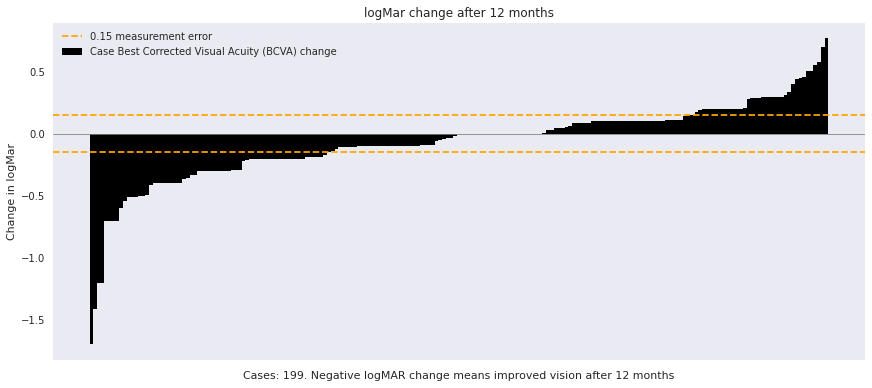

In [27]:
feature = "irf_1_inter_srf_1"
normalize = True

abt_viz_norm = copy.copy(abt_viz)

independent_features = abt_viz_norm.drop("va_change", axis=1).columns.tolist()

if normalize:
    from sklearn.preprocessing import MaxAbsScaler
    transformer = MaxAbsScaler().fit(abt_viz_norm[independent_features])
    abt_viz_norm.loc[:, independent_features] = transformer.transform(abt_viz_norm[independent_features])
else:
    # pre process data table
    abt_viz_norm = outlier_removal(abt_viz_norm, feature)
    feature_norm = normalize(abt_viz_f[feature].values)
    
f = plt.figure(constrained_layout=True, figsize=(12,15))
gs = f.add_gridspec(3, 3)

ks_dict = ks_statistisc_for_features(independent_features, abt_viz_norm)

all_sequences_plot(gs[0,0:], f, table=abt_viz, feature_norm=feature, color_by=False)

plt.show()

## Lasso for Feature Selection

In [ ]:
def outlier_removal(df, feature):
    """
    remove any feature values outsite the 99 % CI
    """
    std_f = np.std(df[feature])
    
    df_filtered = df[np.abs(df[feature]) < np.std(np.abs(df.va_change))*3]
    return df_filtered

# Study 1: Coefficient importance on all data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import r2_score

independent_variables = [feature for feature in ks_dict.keys()]
outcome = "va_change"

abt_viz_norm_f = abt_viz_norm# [np.abs(abt_viz_norm.va_change) >= 0.15]
abt_viz_norm_f = outlier_removal(abt_viz_norm_f, feature="va_change")

lasso = Lasso(alpha=0.0001, normalize=True).fit(abt_viz_norm_f[independent_variables], abt_viz_norm_f["va_change"])

importance = np.abs(lasso.coef_)
feature_names = np.array(independent_variables)

threshold = 0.00
feature_importance = {}
for k, imp in enumerate(importance):
    if imp > threshold:
        feature_importance[feature_names[k]] = (np.round(imp, 2), np.sign(lasso.coef_[k]))
        
print("Number of features selected by Lasso", len(feature_importance))


## Plot most important features

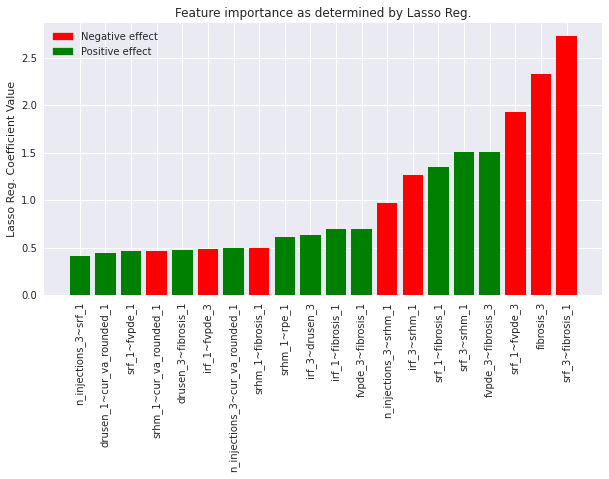

In [62]:
top = 20
feature_importance_sorted = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1][0])}

x = list(feature_importance_sorted.keys())[-top:]
heights = [value[0] for value in feature_importance_sorted.values()][-top:]

color_dict = {-1.0:"green", 1.0:"red"}
colors = [color_dict[value[1]] for value in feature_importance_sorted.values()][-top:]

plt.figure(figsize=(10,5))
plt.bar(x, height=heights, color=colors)
plt.xticks(rotation=90)
plt.ylabel("Lasso Reg. Coefficient Value")
plt.title("Feature importance as determined by Lasso Reg.")

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='red', label='Negative effect')
green_patch = mpatches.Patch(color='green', label='Positive effect')

plt.legend(handles=[red_patch, green_patch])
plt.show()

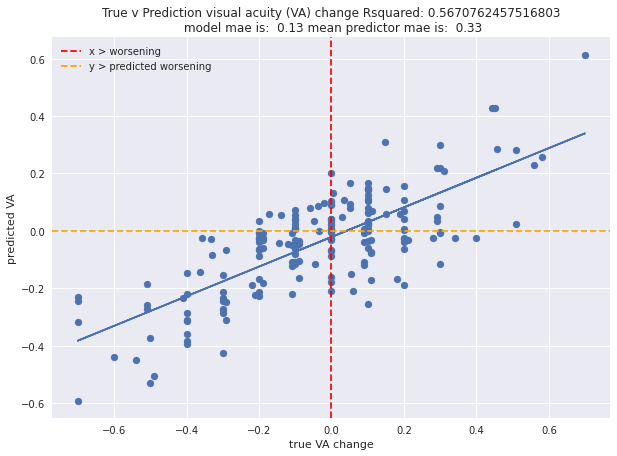

In [63]:
fig = plt.figure(figsize=(10,7))

predictions = lasso.predict(abt_viz_norm_f[independent_variables])
mae = np.mean(np.abs(predictions - abt_viz_norm_f["va_change"]))

plt.scatter(abt_viz_norm_f["va_change"], predictions)

m, b = np.polyfit(abt_viz_norm_f["va_change"], predictions, 1)

plt.plot(abt_viz_norm_f["va_change"], m*abt_viz_norm_f["va_change"] + b)

plt.axvline(x=0.0, linestyle="--", color="red", label="x > worsening")
plt.axhline(y=0.0, linestyle="--", color="orange", label="y > predicted worsening")

str1 = f"True v Prediction visual acuity (VA) change Rsquared: {r2_score(abt_viz_norm_f['va_change'], predictions)}"
str2 = f"\n model mae is:  {np.round(mae, 2)} mean predictor mae is:  0.33"
plt.title(str1 + str2)
plt.xlabel("true VA change")
          
plt.ylabel("predicted VA")
plt.legend()

# Study 2 - Lasso on Cross Validation for predictions

In [69]:
from sklearn.model_selection import LeaveOneOut

features = independent_variables
data = abt_viz_norm_f.reset_index().drop("seq", axis=1)
X = data[features]
y = data[["va_change"]]

loo = LeaveOneOut()
loo.get_n_splits(X)

print(loo)

predictions = []
scores = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y.loc[train_index, :], y.loc[test_index, :]
        
    lasso_cv = Lasso(alpha=0.001, normalize=True).fit(X_train, y_train)
    predictions.extend(list(lasso_cv.predict(X_test)))    

LeaveOneOut()


In [18]:
## plot predictions

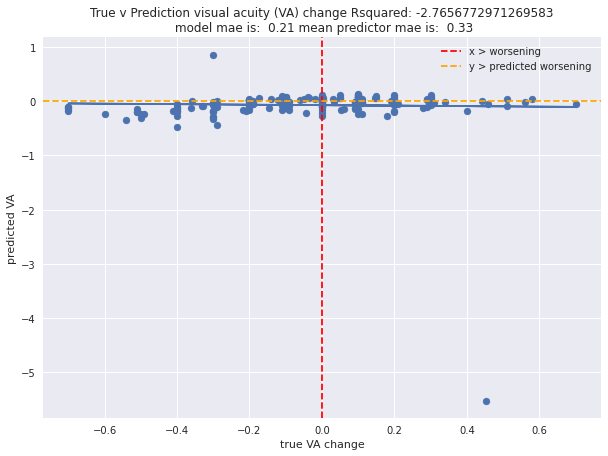

In [70]:
fig = plt.figure(figsize=(10,7))

y_plot = y["va_change"].values

mae = np.mean(np.abs(predictions - y_plot))

plt.scatter(y_plot, predictions)

m, b = np.polyfit(y_plot, predictions, 1)

plt.plot(y, m*y_plot + b)

plt.axvline(x=0.0, linestyle="--", color="red", label="x > worsening")
plt.axhline(y=0.0, linestyle="--", color="orange", label="y > predicted worsening")


str1 = f"True v Prediction visual acuity (VA) change Rsquared: {r2_score(y_plot, predictions)}"
str2 = f"\n model mae is:  {np.round(mae, 2)} mean predictor mae is:  0.33"
plt.title(str1 + str2)
plt.xlabel("true VA change")
plt.ylabel("predicted VA")
plt.legend()

# Study 3 - Ensemble RandomForest

In [71]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import LeaveOneOut

features = independent_variables
data = abt_viz_norm_f.reset_index().drop("seq", axis=1)
X = data[features]
y = data[["va_change"]]

loo = LeaveOneOut()
loo.get_n_splits(X)

print(loo)

predictions = []
scores = []
for train_index, test_index in tqdm.tqdm(loo.split(X)):
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y.loc[train_index, :], y.loc[test_index, :]
        
    lasso_cv = RandomForestRegressor(n_jobs=10).fit(X_train, y_train)
    predictions.extend(list(lasso_cv.predict(X_test)))    

0it [00:00, ?it/s]

LeaveOneOut()


194it [02:35,  1.24it/s]


In [21]:
## plot predictions

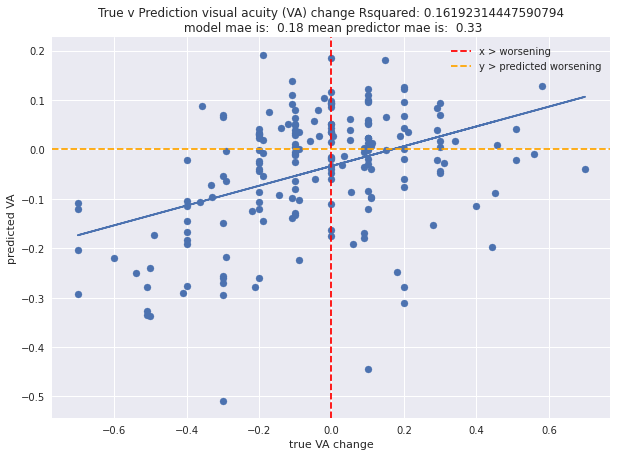

In [72]:
fig = plt.figure(figsize=(10,7))

y_plot = y["va_change"].values

mae = np.mean(np.abs(predictions - y_plot))

plt.scatter(y_plot, predictions)

m, b = np.polyfit(y_plot, predictions, 1)

plt.plot(y, m*y_plot + b)

plt.axvline(x=0.0, linestyle="--", color="red", label="x > worsening")
plt.axhline(y=0.0, linestyle="--", color="orange", label="y > predicted worsening")


str1 = f"True v Prediction visual acuity (VA) change Rsquared: {r2_score(y_plot, predictions)}"
str2 = f"\n model mae is:  {np.round(mae, 2)} mean predictor mae is:  0.33"
plt.title(str1 + str2)
plt.xlabel("true VA change")
plt.ylabel("predicted VA")
plt.legend()

## ANN predictions

In [73]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import LeaveOneOut

features = independent_variables
data = abt_viz_norm_f.reset_index().drop("seq", axis=1)
X = data[features]
y = data[["va_change"]]

loo = LeaveOneOut()
loo.get_n_splits(X)

print(loo)

predictions = []
scores = []
for train_index, test_index in tqdm.tqdm(loo.split(X)):
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y.loc[train_index, :], y.loc[test_index, :]
        
    ann = MLPRegressor(learning_rate="adaptive", early_stopping =False).fit(X_train, y_train)
    predictions.extend(list(ann.predict(X_test)))    

0it [00:00, ?it/s]

LeaveOneOut()


194it [01:13,  2.64it/s]


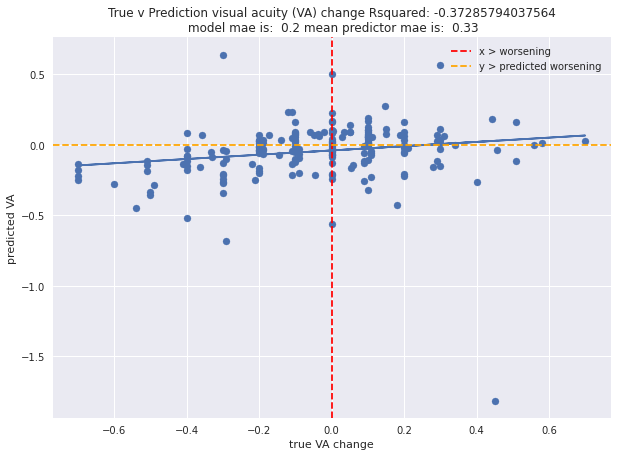

In [74]:
fig = plt.figure(figsize=(10,7))

y_plot = y["va_change"].values

mae = np.mean(np.abs(predictions - y_plot))

plt.scatter(y_plot, predictions)

m, b = np.polyfit(y_plot, predictions, 1)

plt.plot(y, m*y_plot + b)

plt.axvline(x=0.0, linestyle="--", color="red", label="x > worsening")
plt.axhline(y=0.0, linestyle="--", color="orange", label="y > predicted worsening")


str1 = f"True v Prediction visual acuity (VA) change Rsquared: {r2_score(y_plot, predictions)}"
str2 = f"\n model mae is:  {np.round(mae, 2)} mean predictor mae is:  0.33"
plt.title(str1 + str2)
plt.xlabel("true VA change")
plt.ylabel("predicted VA")
plt.legend()

## Feature visualization

In [75]:
feature = "thicknessmean"
region = "C0"

month1 = pd.DataFrame([["month 1"]*abt.shape[0], abt[f"{region}-{feature}_1"]]).T
month3 = pd.DataFrame([["month 3"]*abt.shape[0], abt[f"{region}-{feature}_3"]]).T
month12 = pd.DataFrame([["month 12"]*abt.shape[0], abt[f"{region}-{feature}_12"]]).T

month_pd = month1.append(month3).append(month12)

month_pd = month_pd.rename(columns={0: "visit", 1:feature})

ax = sns.boxplot(x="visit", y=feature, data=month_pd)
plt.title(f"{region}-{feature}")

KeyError: 'C0-thicknessmean_1'